# Fase 1: preprocessing & Model Training

Equipo 55

Nombres y matrículas de los integrantes del Equipo:

*   Mario Arturo Salinas Rodriguez - A01796938
*   Ivan Rodriguez Apolinar - A01796052
*   Kailin Wu - A00830574
*   Jorge Zepeda Tinoco - A01797233
*   Marilyn Sofia Mori Castillo - A01796415

In [18]:
# Importar librerías
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint, uniform

pd.set_option('display.max_columns', None)

In [2]:
# Leer datos
df = pd.read_parquet('../../data/clean/steel_energy_clean.parquet')
df.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,mixed_type_col
index,,,,,,,,,,,,
0,2018-01-01 00:15:00,3.17,2.95,0.000000,2.605081,73.21,100.0,900.0,WEEKDAY,MONDAY,LIGHT_LOAD,649.0
1,2018-01-01 00:30:00,4.00,4.46,7.568952,0.000000,66.77,100.0,1800.0,WEEKDAY,MONDAY,LIGHT_LOAD,495.0
2,2018-01-01 00:45:00,3.24,3.28,0.000000,0.000000,70.28,100.0,2700.0,WEEKDAY,MONDAY,LIGHT_LOAD,696.0
3,2018-01-01 01:00:00,3.31,3.56,0.000000,0.000000,68.09,100.0,3600.0,WEEKDAY,MONDAY,LIGHT_LOAD,630.0
4,2018-01-01 01:15:00,3.82,4.50,0.000000,0.000000,64.72,100.0,4500.0,WEEKDAY,MONDAY,LIGHT_LOAD,325.0


In [3]:
# Train test split
target_col = 'Load_Type'
X, y = df.drop(target_col, axis=1), df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)

In [4]:
# Conseguir variables numericas y variables categoricas
cat_cols = list(X.select_dtypes('object').columns)
num_cols = list(X.select_dtypes('number').columns)

In [5]:
# Generar ColumnTransformer como pipeline general de Preprocesamiento
preprocessing = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(), cat_cols)
])

In [6]:
# Crear el pipeline del modelo
rf_model = make_pipeline(preprocessing, 
                         RandomForestClassifier())

# Entrenar el modelo
rf_model.fit(X_train, y_train)

# Predicciones
y_pred = rf_model.predict(X_test)

In [ ]:
# Visualizar métricas de clasificación
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

  LIGHT_LOAD       0.96      0.97      0.97      3645
MAXIMUM_LOAD       0.77      0.81      0.79      1457
 MEDIUM_LOAD       0.82      0.78      0.80      1981

    accuracy                           0.88      7083
   macro avg       0.85      0.85      0.85      7083
weighted avg       0.88      0.88      0.88      7083



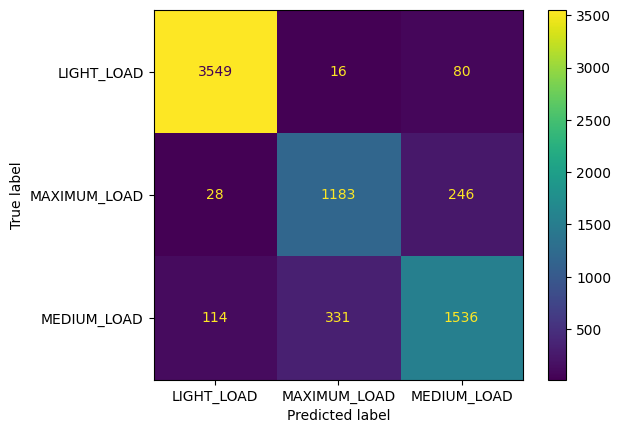

In [14]:
# Visualizar matriz de confusión
cf = confusion_matrix(y_test, y_pred, labels=rf_model.classes_)
disp = ConfusionMatrixDisplay(cf, display_labels=rf_model.classes_)
disp.plot();